In [1]:
import numpy as np
import math
import sys
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from itertools import combinations_with_replacement

# from sklearn.preprocessing import normalize
#from ml_from_scratch.utils import normalize, standardize, polynomial_features

### Utils

In [2]:
def polynomial_features(X, degree):
    n_samples, n_features = np.shape(X)

    def index_combinations():
        combs = [combinations_with_replacement(range(n_features), i) for i in range(0, degree + 1)]
        flat_combs = [item for sublist in combs for item in sublist]
        return flat_combs
    
    combinations = index_combinations()
    n_output_features = len(combinations)
    X_new = np.empty((n_samples, n_output_features))
    
    for i, index_combs in enumerate(combinations):  
        X_new[:, i] = np.prod(X[:, index_combs], axis=1)

    return X_new


def normalize(X, axis=-1, order=2):
    """Normalise the dataset (unit norm)
        Axis:0 => Each feature(column) is normalised to unit norm
        Axis:1 => Each sample(row) is normalised to unit norm
        X = X / sqrt(|X|^2)
    """
    norm = np.atleast_1d(np.linalg.norm(X, ord=order, axis=axis))
    norm[norm == 0] = 1
    return X / np.expand_dims(norm, axis=axis)


def standardize(X):
    """Standardize the dataset to make features
    zero mean and unit variance
    """
    return (X - X.mean(axis=0)) / X.std(axis=0)

def mean_squared_error(y_true, y_pred):
    """ Returns the mean squared error between y_true and y_pred """
    #mse = np.mean(np.power(y_true - y_pred, 2))
    mse = np.mean((y_true - y_pred)**2)
    return mse

In [3]:
class l1_regularization():
    """Lasso regularization
    """
    def __init__(self, alpha):
        self.alpha = alpha
    
    def __call__(self, w):
        return self.alpha * np.linalg.norm(w, ord=1)
    
    def grad(self, w):
        return self.alpha * np.sign(w)

class l2_regularization():
    """ L2 regularization """
    def __init__(self, alpha):
        self.alpha = alpha
    
    def __call__(self, w):
        return self.alpha * 0.5 * ((w.T @ w).item())
        # return self.alpha * 0.5 * ((w.T).dot(w).item())
        # return self.alpha * 0.5 * np.linalg.norm(w, ord=2)**2
    
    def grad(self, w):
        return self.alpha * w


class l1_l2_regularization():
    """Elastic net regularization"""
    def __init__(self, alpha, l1_ratio):
        self.alpha = alpha
        self.l1_ratio = l1_ratio
    
    def __call__(self, w):
        l1_reg = self.l1_ratio * np.linalg.norm(w, ord=1)
        l2_reg = (1 - self.l1_ratio) * 0.5 * (w.T @ w).item()
        return self.alpha * (l1_reg + l2_reg)
    
    def grad(self, w):
        return self.alpha * (self.l1_ratio * np.sign(w) + (1-self.l1_ratio)*w)

### Regression implementation

In [4]:
class Regression(object):
    """
    Models relationship b/w  independent variables X and dependent variable y
    Base class for linear regression models
    Parameters
    ----------
    n_iterations: float
        Number of training iterations
    learning_rate: float
        Step size of optimisation algorithm
    """

    def __init__(self, n_iterations, learning_rate):
        self.n_iterations = n_iterations
        self.learning_rate = learning_rate
    
    def initialize_weights(self, n_features):
        """Initialise weights randomly b/w [-1/sqrt(N) 1/sqrt(N)]"""
        limit = 1 / math.sqrt(n_features)
        self.w = np.random.uniform(-limit, limit, (n_features, 1))
    
    def fit(self, X, y):
        """Learn parameters using supervised data"""
        # Insert column of 1s for bias term
        X = np.insert(X, 0, 1, axis=1)
        # Initialise weights
        self.initialize_weights(n_features=X.shape[1])
        self.training_errors = []

        # Gradient descent for n_iterations
        for i in range(self.n_iterations):
            # Predicted output
            # y_pred = X.dot(self.w)
            y_pred = X @ self.w
            # Error (target - predicted)
            # L2 Loss
            mse = np.mean(0.5*(y - y_pred)**2) + self.regularization(self.w)
            self.training_errors.append(mse)
            # Gradient of error
            #grad_w = -(y - y_pred).dot(X) + self.regularization.grad(self.w) #will work only if y has dimensions (n,)
            grad_w = -(X.T) @ (y - y_pred) + self.regularization.grad(self.w)
            #print(grad_w.shape)
            #print(self.w.shape)
            # Gradient descent step
            self.w -= self.learning_rate * grad_w
    
    def predict(self, X):
        """Predictions for new data"""
        X = np.insert(X, 0, 1, axis=1)
        y_pred = X.dot(self.w)
        return y_pred

In [5]:
class LinearRegression(Regression):
    """Linear Regression Model
    """
    def __init__(self, n_iterations=100, learning_rate=0.0001, gradient_descent=True):
        self.gradient_descent = gradient_descent
        # No regularisation
        self.regularization = lambda x: 0
        self.regularization.grad = lambda x: 0
        super(LinearRegression, self).__init__(n_iterations=n_iterations, learning_rate=learning_rate)
    
    def fit(self, X, y):
        """
        If gradient descent use base class's fit
        If not gradient descent use normal equations (inverse using SVD)
        """
        if self.gradient_descent:
            super(LinearRegression, self).fit(X, y)
        else:
            X = np.insert(X, 0, 1, axis=1)
            """
            # Moore-Penrose pseudo inverse using SVD (TODO: incorrect estimates)
            U, S, V = np.linalg.svd(X.T.dot(X))
            S = np.diag(S)
            Xtx_inv = V.dot(np.linalg.pinv(S)).dot(U.T)
            self.w = Xtx_inv.dot(X.T).dot(y)
            """
            self.w = np.linalg.pinv(X.T.dot(X)).dot(X.T).dot(y) # Normal equation, psuedo inverse
            self.training_errors = []
            

In [6]:
class PolynomialRegression(Regression):
    """Performs a non-linear transformation of the data before fitting the model
    and doing predictions which allows for doing non-linear regression.
    Parameters:
    ----------
    degree: float
        Polynomial degree
    """
    def __init__(self, degree, n_iterations=1000, learning_rate=0.001):
        self.degree = degree
        self.regularization = lambda x: 0
        self.regularization.grad = lambda x: 0
        super(PolynomialRegression, self).__init__(n_iterations=n_iterations, learning_rate=learning_rate)
    
    def fit(self, X, y):
        X = polynomial_features(X, degree=self.degree)
        super(PolynomialRegression, self).fit(X, y)
    
    def predict(self, X):
        X = polynomial_features(X, degree=self.degree)
        return super(PolynomialRegression, self).predict(X)



class LassoRegression(Regression):
    """Lasso Regression (with polynomial features) - l1 regularisation
    Paramaters:
    ----------
    degree: int
        Degree of polynomial features
    reg_factor: float
        Regularisation parameter (Feature shrinkage)
    """
    def __init__(self, degree, reg_factor, n_iterations=100, learning_rate=0.0001):
        self.degree = degree
        self.regularization = l1_regularization(alpha = reg_factor)
        super(LassoRegression, self).__init__(n_iterations=n_iterations, learning_rate=learning_rate)
    
    def fit(self, X, y):
        # [TODO - High error with polynomial features]
        #X = normalize(polynomial_features(X, degree=self.degree))
        super(LassoRegression, self).fit(X, y)
    
    def predict(self, X):
        #X = normalize(polynomial_features(X, degree=self.degree))
        return super(LassoRegression, self).predict(X)


class RidgeRegression(Regression):
    """Ridge Regression (with polynomial features) - l2 regularisation
    Paramaters:
    ----------
    degree: int
        Degree of polynomial features
    reg_factor: float
        Regularisation parameter (Feature shrinkage)
    """
    def __init__(self, degree, reg_factor, n_iterations=100, learning_rate=0.0001):
        self.degree = degree
        self.regularization = l2_regularization(alpha = reg_factor)
        super(RidgeRegression, self).__init__(n_iterations=n_iterations, learning_rate=learning_rate)
    
    def fit(self, X, y):
        #X = normalize(polynomial_features(X, degree=self.degree))
        super(RidgeRegression, self).fit(X, y)
    
    def predict(self, X):
        #X = normalize(polynomial_features(X, degree=self.degree))
        return super(RidgeRegression, self).predict(X)


class ElasticNet(Regression):
    """Regression (with polynomial features) - with l1 and l2 regularisation
    Paramaters:
    ----------
    degree: int
        Degree of polynomial features
    reg_factor: float
        Regularisation parameter (Feature shrinkage)
    
    """
    def __init__(self, degree, reg_factor, l1_ratio, n_iterations=100, learning_rate=0.0001):
        self.degree = degree
        self.regularization = l1_l2_regularization(alpha = reg_factor, l1_ratio=l1_ratio)
        super(ElasticNet, self).__init__(n_iterations=n_iterations, learning_rate=learning_rate)
    
    def fit(self, X, y):
        #X = normalize(polynomial_features(X, degree=self.degree))
        super(ElasticNet, self).fit(X, y)
    
    def predict(self, X):
        #X = normalize(polynomial_features(X, degree=self.degree))
        return super(ElasticNet, self).predict(X)

### Regression Examples

In [7]:
n_samples = 100
n_features = 1
test_size = 0.25
n_iterations = 100
learning_rate = 0.001

# Create dataset
X, y = make_regression(n_samples=n_samples, n_features=n_features, noise=0)

# Create train, test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)
#print(X_train.shape)

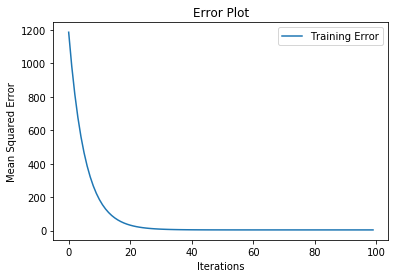

In [8]:
# Reshape
y = y.reshape(y.shape[0], 1)
y_train = y_train.reshape(y_train.shape[0], 1)
y_test = y_test.reshape(y_test.shape[0], 1)

#model = LinearRegression(n_iterations=100, learning_rate=learning_rate, gradient_descent=True)
model = LassoRegression(degree=1, reg_factor=0.1, n_iterations=100, learning_rate=learning_rate)
#model = RidgeRegression(degree=1, reg_factor=0.1, n_iterations=100, learning_rate=learning_rate)
#model = ElasticNet(degree=1, reg_factor=0.1, l1_ratio=0.25, n_iterations=100, learning_rate=learning_rate)

model.fit(X_train, y_train)
y_pred = model.predict(X_test)
#print(mean_squared_error(y_pred, y_test))

# Training error plot
n = len(model.training_errors)
training, = plt.plot(range(n), model.training_errors, label="Training Error")
plt.legend(handles=[training])
plt.title("Error Plot")
plt.ylabel('Mean Squared Error')
plt.xlabel('Iterations')
plt.show()

In [9]:
mean_squared_error(y_pred, y_test)

6.527709073538586e-05